# Plot Speed-Accuracy Tradeoff (SAT) Curve
Step 3. in
1. Generate Nosaic MNIST (`python make_nmnist.py`).
2. Extract and save features in TFRecords format (save_featureTFR_nmnist.ipynb).
3. Plot SAT curve (plot_SAT_curve.ipynb)

In [1]:
from __future__ import absolute_import, division, print_function

import os, sys, glob
from itertools import zip_longest
import optuna, sqlite3
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from datasets.data_processing import read_tfrecords_nosaic_mnist,\
    decode_feat, sequential_slice
from models.backbones_ti import LSTMModelLite
from models.losses import get_loss_lstm
from utils.misc import load_yaml, set_gpu_devices, fix_random_seed
from utils.performance_metrics import multiplet_sequential_confmx,\
    binary_llr_sequential_confmx, confmx_to_metrics, seqconfmx_to_list_metrics,\
    list_metrics_to_list_bac, dict_confmx_to_dict_metrics, run_truncated_sprt,\
    calc_binary_llrs, binary_avescr_test, binary_np_test

In [2]:
# Which GPU to be used
set_gpu_devices(0)

# User-defined params

In [3]:
# User-defined
order_sprt = 10 # 1 or 10 are supported for demonstration
num_plot = 50 # how many thresholds to be used to plot SAT curve
num_traj = 100 # how many sequential datapoints to be used to plot LLR trajectories

tfr_train = "./data-directory/nosaic_mnist_feat_train.tfrecords" # bottleneck feature
tfr_test = "./data-directory/nosaic_mnist_feat_test.tfrecords" # bottleneck feature
batch_size = 200 # must be a divisor of the num of test datapoints

In [4]:
# Fix 
if order_sprt == 1:
    name_model = "./example_ckpts/temporal_integrator/LSTM_1st_order_SPRT-TANDEM"
if order_sprt == 10:
    name_model = "./example_ckpts/temporal_integrator/LSTM_10th_order_SPRT-TANDEM"
duration = 20
feat_dim = 128
nb_cls = 2
width_lstm = feat_dim 
dropout = 0.
activation = "tanh" 

# 0. Start calc logits and LLRs
In our environment, we saw lots of `W0525 07:31:48.780274 139669605709568 util.py:144] Unresolved object in checkpoint: (root).optimizer's state 'v' for (root).net.fc_logit.kernel` and so on, but no problem for us.

In [5]:
# Load data
##################################
# Reed tfr and make 
parsed_image_dataset_train, parsed_image_dataset_valid, parsed_image_dataset_test = \
    read_tfrecords_nosaic_mnist(
        record_file_train=tfr_train, 
        record_file_test=tfr_test, 
        batch_size=batch_size, 
        shuffle_buffer_size=2000)

# Model
##################################
model = LSTMModelLite(
    nb_cls=nb_cls, 
    width_lstm=width_lstm, 
    dropout=dropout, 
    activation=activation) 

# Restore parameters
#################################
ckpt = tf.train.Checkpoint(net=model)
ckpt_manager_restore = tf.train.CheckpointManager(ckpt,
    name_model, max_to_keep=3)
ckpt.restore(ckpt_manager_restore.latest_checkpoint)
print("Restored latest model\n{}".format(
    ckpt_manager_restore.latest_checkpoint)) 

# Evaluaton loop
##################################
for iter_b, feats in enumerate(parsed_image_dataset_test):
    cnt = iter_b + 1

    # Decode features and binarize classification labels
    x_batch, y_batch = decode_feat(feats, duration, feat_dim, 
        dtype_feat=tf.float32, dtype_label=tf.int32)

    # Calc logits 
    if iter_b == 0:
        # Calc loss
        _, logits_tmp = get_loss_lstm(model, x_batch,y_batch,
            training=False, order_sprt=order_sprt)
        logits_all = logits_tmp
        labels_all = y_batch

    else:
        _, logits_tmp = get_loss_lstm(model, x_batch, y_batch, 
            training=False, order_sprt=order_sprt)
        logits_all = tf.concat([logits_all, logits_tmp], 0)
        labels_all = tf.concat([labels_all, y_batch], 0)

    # Verbose
    if ((iter_b+1)%10 == 0) or (iter_b == 0):
        sys.stdout.write("\rEvaluation Iter: {:3d}".format(iter_b+1))
        sys.stdout.flush()

Restored latest model
./example_ckpts/temporal_integrator/LSTM_10th_order_SPRT-TANDEM/ckpt_step3100_mbac0.97091-21
Evaluation Iter:  50

In [6]:
# Generate Thresholds for SPRT
llrs_all = calc_binary_llrs(logits_all)
llrmin = tf.reduce_min(tf.abs(llrs_all))
llrmax = tf.reduce_max(tf.abs(llrs_all))
logmin = 1 / (1 + np.exp(llrmin))
logmax = 1 / (1 + np.exp(llrmax))
list_alpha = np.logspace(np.log10(logmax), np.log10(logmin), num_plot, base=10, endpoint=False)
list_beta = list_alpha

# Show thresholds
thresh = [np.log(list_beta/(1-list_alpha)), np.log((1-list_beta)/list_alpha)]
if not ( np.any(thresh[1] >= thresh[0]) and np.any(thresh[1] * thresh[0] < 0) ):
   raise ValueError(
       "thresh must be thresh[1] >= thresh[0] and thresh[1] * thresh[0] < 0. Now thresh = {}".format(thresh))

thresh

[array([-24.00287625, -23.53668327, -23.0704903 , -22.60429733,
        -22.13810435, -21.67191138, -21.20571841, -20.73952543,
        -20.27333246, -19.80713948, -19.34094651, -18.87475353,
        -18.40856056, -17.94236758, -17.4761746 , -17.00998161,
        -16.54378861, -16.0775956 , -15.61140256, -15.14520949,
        -14.67901636, -14.21282314, -13.74662976, -13.28043615,
        -12.81424217, -12.34804758, -11.88185203, -11.41565495,
        -10.94945543, -10.48325202, -10.01704242,  -9.55082294,
         -9.08458771,  -8.61832738,  -8.15202705,  -7.68566292,
         -7.21919709,  -6.75256904,  -6.28568221,  -5.81838229,
         -5.3504224 ,  -4.88140664,  -4.41069785,  -3.93726463,
         -3.45942184,  -2.97437486,  -2.47737543,  -1.96002912,
         -1.40647333,  -0.78302693]),
 array([24.00287625, 23.53668327, 23.0704903 , 22.60429733, 22.13810435,
        21.67191138, 21.20571841, 20.73952543, 20.27333246, 19.80713948,
        19.34094651, 18.87475353, 18.40856056, 1

In [7]:
# run truncated SPRT
dict_confmx_sprt, dict_mean_hittimes, dict_var_hittimes,\
    dict_truncate_rates = run_truncated_sprt(
        list_alpha,
        list_beta, 
        logits_all, 
        labels_all, 
        verbose=False)
dict_metrics_sprt = dict_confmx_to_dict_metrics(dict_confmx_sprt)

# Balanced accuracy, mean hitting time, stdev of hitting times 
list_mht = []
list_stdevht = []
list_bac = []
for iter_num, key in enumerate(dict_metrics_sprt.keys()):
    # Verbose
    if (iter_num == 0) or ((iter_num + 1) % 50 == 0) or ((iter_num + 1) == len(dict_metrics_sprt)):
        print("Thresh Iter {}/{} {}".format(iter_num + 1, len(dict_metrics_sprt), key))

    metrics_test = dict_metrics_sprt[key]
    list_bac.append(float(metrics_test["BAC"][0]))
    list_mht.append(float(dict_mean_hittimes[key]))
    list_stdevht.append(float(np.sqrt(dict_var_hittimes[key])))

Thresh Iter 1/50 thresh=-2.9744, 2.9744
Thresh Iter 50/50 thresh=-9.5508, 9.5508


# 1. Plot SAT (Speed-Accuracy Tradeoff) Curve

balanced accuracy := 0.5 * (true positive rate + true negative rate) is robust to class-imbalance.

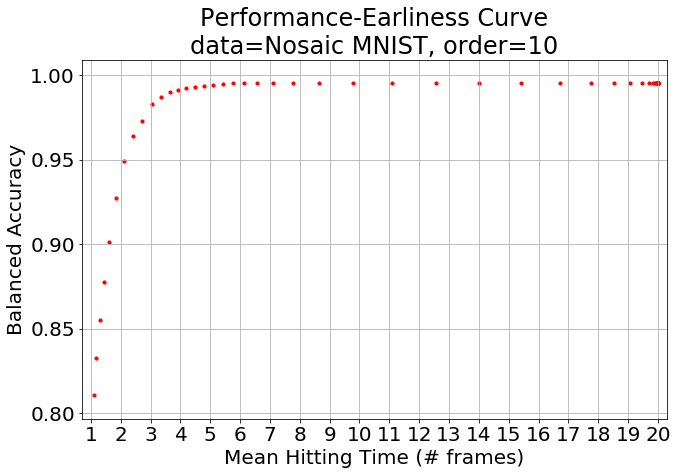

In [8]:
# Start plotting SP curve
######################################
# Parameters
x = list_mht
y = list_bac
name_dataset = "Nosaic MNIST"

title = "Performance-Earliness Curve\ndata={}, order={}".format(name_dataset, order_sprt)
xlabel = "Mean Hitting Time (# frames)"
ylabel = "Balanced Accuracy"

# Plot
plt.rcParams["font.size"] = 20
plt.figure(figsize=(10,7))

plt.scatter(
    x, y, 
    s=10, 
    color="red", 
    marker='o', 
    vmin=None, 
    vmax=None, 
    alpha=None, 
    linewidths=None,
    edgecolors=None
    )

plt.xlabel(xlabel)
plt.ylabel(ylabel)        
#plt.xscale("log")
plt.grid(True)
plt.title(title)
plt.xticks([i for i in range(1, duration + 1)])
plt.xlim(0.7, duration+0.3)
plt.tight_layout()

# Save figure
#plt.savefig(***)

## 1-1. NPT (Neyman-Pearson Test)

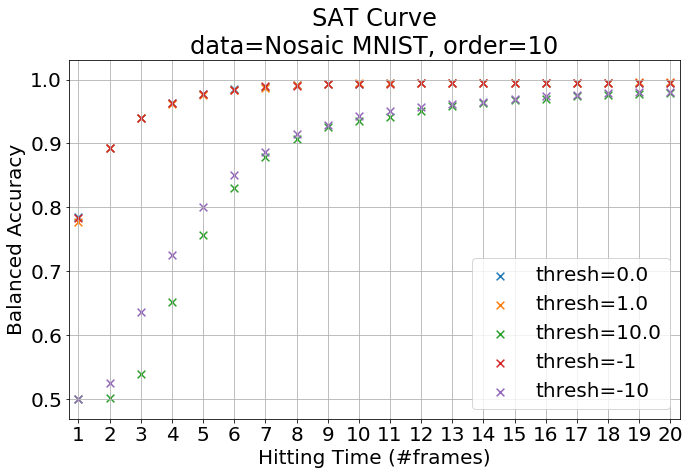

In [9]:
list_thresh_np = [0., 1., 10., -1, -10]

title = "SAT Curve\ndata=Nosaic MNIST, order={}".format(order_sprt)
label = "SPRT"
xlabel = "Hitting Time (#frames)"
ylabel = "Balanced Accuracy"

plt.rcParams["font.size"] = 20
plt.figure(figsize=(10,7))

for thresh_np in list_thresh_np:
    list_nplen = [i+1 for i in range(duration)]
    list_npbac = []
    llrs_all = calc_binary_llrs(logits_all)

    # NP test
    for iter_nplen in list_nplen:
        confmx = binary_np_test(
                llrs_all, 
                labels_all,
                length=iter_nplen,
                thresh=thresh_np)

        list_npbac.append(confmx_to_metrics(confmx)["BAC"][0].numpy())


    # Plot NPT vs SPRT
    ###############################
    # Parameters
    x = list_mht
    y = list_bac


    # Plot NPT
    plt.scatter(
        list_nplen, list_npbac, 
        s=60, 
        #color="blue", 
        marker='x', 
        vmin=None, 
        vmax=None, 
        alpha=None, 
        linewidths=None,
        edgecolors=None,
        label="thresh={}".format(thresh_np)
        )

plt.xlabel(xlabel)
plt.ylabel(ylabel)        
#plt.xscale("log")
plt.grid(True)
plt.legend()
plt.title(title)
plt.xticks([i for i in range(1, duration + 1)])
plt.xlim(0.7, 20.3)
plt.tight_layout()

# Save figure
#plt.savefig(***)

## 1-2. SPRT vs NPT

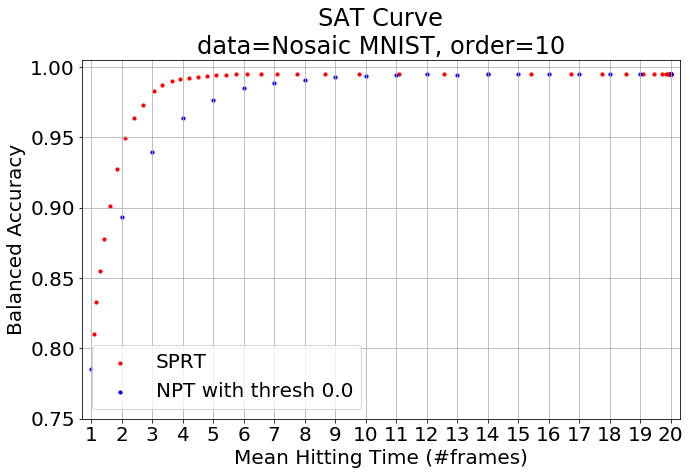

In [10]:
# Parameters
thresh = 0.
list_nplen = [i+1 for i in range(duration)]
list_npbac = []
llrs_all = calc_binary_llrs(logits_all)

# NP test
for iter_nplen in list_nplen:
    confmx = binary_np_test(
            llrs_all, 
            labels_all,
            length=iter_nplen,
            thresh=thresh)

    list_npbac.append(confmx_to_metrics(confmx)["BAC"][0].numpy())

# Plot NPT vs SPRT
###############################
# Parameters
x = list_mht
y = list_bac
title = "SAT Curve\ndata=Nosaic MNIST, order={}".format(order_sprt)
label = "SPRT"
xlabel = "Mean Hitting Time (#frames)"
ylabel = "Balanced Accuracy"

plt.rcParams["font.size"] = 20
plt.figure(figsize=(10,7))

# Plot SPRT
plt.scatter(
    x, y, 
    s=10, 
    color="red", 
    marker='o', 
    vmin=None, 
    vmax=None, 
    alpha=None, 
    linewidths=None,
    edgecolors=None,
    label=label
    )

# Plot NPT
plt.scatter(
    list_nplen, list_npbac, 
    s=10, 
    color="blue", 
    marker='o', 
    vmin=None, 
    vmax=None, 
    alpha=None, 
    linewidths=None,
    edgecolors=None,
    label="NPT with thresh {}".format(thresh)
    )

plt.xlabel(xlabel)
plt.ylabel(ylabel)        
#plt.xscale("log")
plt.grid(True)
plt.legend()
plt.title(title)
plt.xticks([i for i in range(1, duration + 1)])
plt.xlim(0.7, 20.3)
plt.ylim(0.75, 1.005)
plt.tight_layout()

# Save figure
# plt.savefig(***)

# 2. Plot SAT Curve with Standard Deviation of Hitting Times

(0.95, 0.998)

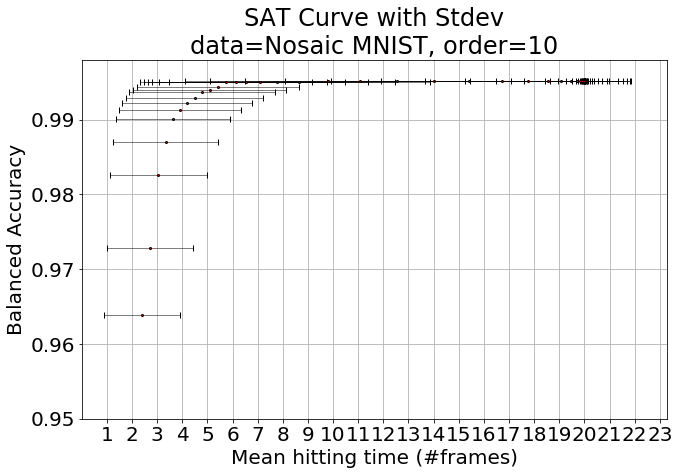

In [11]:
# Start plotting SP curve with variance
######################################
# Parameters
x = list_mht
y = list_bac
x_err = list_stdevht
title = "SAT Curve with Stdev\ndata=Nosaic MNIST, order={}".format(order_sprt)
label = "label"
xlabel = "Mean hitting time (#frames)"
ylabel = "Balanced Accuracy"

# Plot
plt.rcParams["font.size"] = 20
plt.figure(figsize=(10,7))

plt.errorbar(
    x, y, 
    xerr = x_err, 
    capsize=3, 
    fmt='o', 
    markersize=2, 
    ecolor='black', 
    markeredgecolor = "black", 
    color='red',
    elinewidth=0.5)

plt.xlabel(xlabel)
plt.ylabel(ylabel)        
#plt.xscale("log")
plt.grid(True)
#plt.legend(bbox_to_anchor=(0.15, 0, 0.4, 0.9))
#plt.legend()
plt.title(title)
plt.tight_layout()
plt.xticks([i for i in range(1, duration + 4)])
plt.xlim(0., 23.3)
plt.ylim(0.95, 0.998)

# Save figure
# plt.savefig(***)

# 3. Plot Trajectories of LLRs

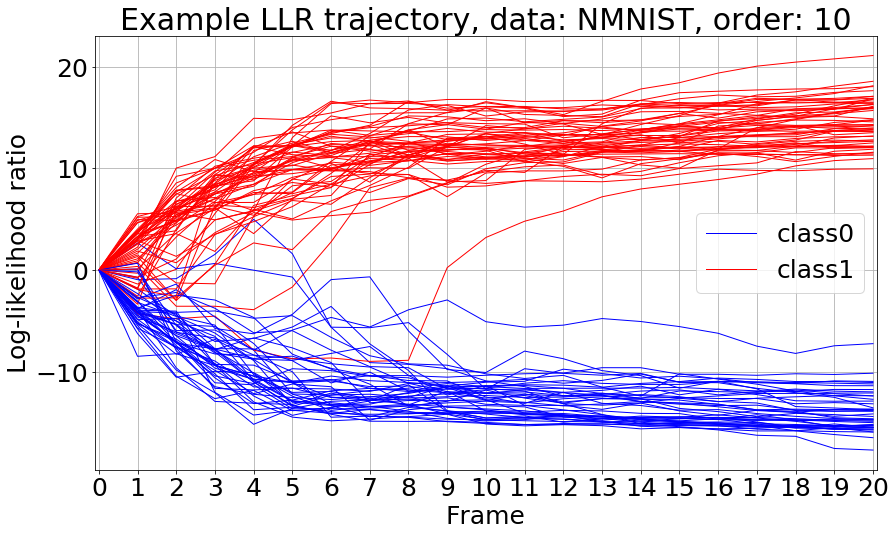

In [12]:
# Start plotting trajectory
######################################
idx_perm = np.random.permutation(labels_all.shape[0])[:num_traj] # randomly take some LLRs
llrs_plot = calc_binary_llrs(logits_all.numpy()[idx_perm])
labels_plot = labels_all.numpy()[idx_perm]

# Parameters
title = "Random example LLR trajectory, data: NMNIST, order: {}".format(order_sprt)
xlabel = "Frame"
ylabel = "Log-likelihood ratio"

plt.rcParams["font.size"] = 25
plt.figure(figsize=(13,8)) 
x = [i for i in range(0, duration+1)]
fl1 = True
fl0 = True
for llrs, label in zip(llrs_plot, labels_plot):
    y = np.append(0, llrs)
    if label == 1:
        color = "red"
    else:
        color = "blue"

    # Plot
    if fl1 and (label == 1):
        plot_label = "class1"
        fl1 = False
    elif fl0 and (label == 0):
        plot_label = "class0"
        fl0 = False
    else:
        plot_label = None
    plt.plot(
        x, y, 
        color=color, 
        marker='o', 
        linewidth=1, 
        markersize=0,
        label=plot_label
        )
    cnt += 1

plt.xlabel(xlabel)
plt.ylabel(ylabel)        
plt.grid(True)
plt.legend()
plt.title(title)
plt.xticks([i for i in range(0, duration + 1)])
plt.xlim(-0.1, 20.1)

plt.tight_layout()

# Save figure 
# plt.savefig(
#     "./traj_order{}.svg".format(order_sprt), 
#     format="svg", 
#     dpi=1200)